In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
#import pydicom
import os
import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation
import matplotlib.pyplot as plt
import math
import time
import cv2 as cv
from PIL import Image
from google.colab.patches import cv2_imshow

from tensorflow.keras.applications import VGG16, DenseNet201, ResNet152V2, NASNetLarge
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#data reading
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/results/results_sample_data_2.csv")#değişecek

from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

df.Class = df.Class.astype(str)
datagen = ImageDataGenerator()

target_size=(128,128)#değişecek

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Veri kümesini bölme işleminden sonra etiketleri one-hot encode et
label_encoder = LabelEncoder()

train_labels = label_encoder.fit_transform(train_df['Class'])
val_labels = label_encoder.transform(val_df['Class'])

# One-hot encoding
train_labels_one_hot = to_categorical(train_labels)
val_labels_one_hot = to_categorical(val_labels)
# Create separate data generators for training and validation
train_data_generator = ImageDataGenerator(
    # Your data augmentation and preprocessing parameters here
).flow_from_dataframe(
    dataframe=train_df,
    x_col="Image_mask_path",#değişecek
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='categorical',
    shuffle=True,
    target_size=target_size,
)

val_data_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=val_df,
    x_col="Image_mask_path",#değişecek
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='categorical',
    shuffle=False,  # No need to shuffle validation data
    target_size=target_size,
)

Found 4236 validated image filenames belonging to 5 classes.
Found 1059 validated image filenames belonging to 5 classes.


In [4]:
class RockPaperScissorsVgg16:
    def __init__(self, input_width, input_height):
        self.input_shape = (input_width, input_height, 3)
        self.classes = 5
        self.model = None
        self.build_model()

    def build_model(self):
        vgg16 = VGG16(weights='imagenet', input_shape=self.input_shape, classes=self.classes, include_top=False)

        for layer in vgg16.layers:
            layer.trainable = False

        x = Flatten()(vgg16.output)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.classes, activation='softmax')(x)

        self.model = Model(inputs=vgg16.input, outputs=predictions)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
vgg16 = RockPaperScissorsVgg16(128,128)
model = vgg16.model
model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [6]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
h=model.fit(
        train_data_generator,
        steps_per_epoch=4236   //64,
                    epochs = 20,
                    validation_data=val_data_generator,
                    validation_steps= 1059 // 64,
        callbacks=[callback]
    )

Epoch 1/20
66/66 [==============================] - 4044s 61s/step - loss: 1.6913 - accuracy: 0.5834 - val_loss: 0.6947 - val_accuracy: 0.7393
Epoch 2/20
66/66 [==============================] - 37s 568ms/step - loss: 0.7852 - accuracy: 0.6767 - val_loss: 0.5885 - val_accuracy: 0.7676
Epoch 3/20
66/66 [==============================] - 32s 490ms/step - loss: 0.6967 - accuracy: 0.7138 - val_loss: 0.5541 - val_accuracy: 0.7959
Epoch 4/20
66/66 [==============================] - 33s 495ms/step - loss: 0.6598 - accuracy: 0.7196 - val_loss: 0.5117 - val_accuracy: 0.7998
Epoch 5/20
66/66 [==============================] - 33s 499ms/step - loss: 0.6148 - accuracy: 0.7469 - val_loss: 0.5247 - val_accuracy: 0.8008
Epoch 6/20
66/66 [==============================] - 36s 552ms/step - loss: 0.5940 - accuracy: 0.7481 - val_loss: 0.4850 - val_accuracy: 0.8037
Epoch 7/20
66/66 [==============================] - 33s 499ms/step - loss: 0.5887 - accuracy: 0.7447 - val_loss: 0.4807 - val_accuracy: 0.8105

17/17 [==============================] - 10s 586ms/step


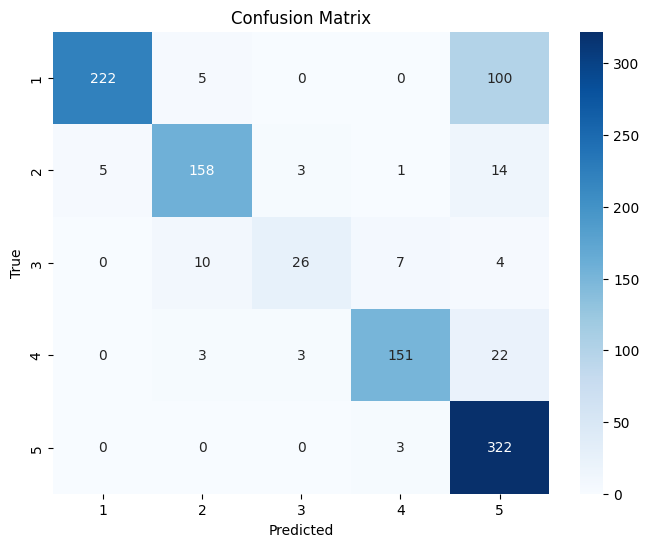

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# Modeli kullanarak tahminler yapın
y_pred = model.predict(val_data_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketleri alın
y_true = val_data_generator.classes

# Confusion matrix oluşturun
cm = confusion_matrix(y_true, y_pred_classes)
class_names=[1,2,3,4,5]
# Matrisi görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Sınıflandırma raporu oluştur
report = classification_report(y_true, y_pred_classes)

# Raporu yazdır
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80       327
           1       0.90      0.87      0.89       181
           2       0.81      0.55      0.66        47
           3       0.93      0.84      0.89       179
           4       0.70      0.99      0.82       325

    accuracy                           0.83      1059
   macro avg       0.86      0.79      0.81      1059
weighted avg       0.86      0.83      0.83      1059

